In [1]:
import sys

import numpy as np
import xscen as xs
import xarray as xr
import cartopy.crs as ccrs
from xscen.config import CONFIG
import figanos.matplotlib as fg
import matplotlib.pyplot as plt
from matplotlib import colors

fg.utils.set_mpl_style('ouranos')

# Load configuration
xs.load_config(
    "../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True
)

In [2]:
pcat = xs.ProjectCatalog(CONFIG["paths"]["project_catalog"])
pcat_df = pcat.df

Processing variable: tg_mean_annual_clim_std

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Skipping tg_mean_annual_clim_std — Horizon: 1981-2010 (annual data)
	Skipping tg_mean_annual_clim_std — Horizon: 1991-2020 (annual data)
Processing variable: tg_mean_annual_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Skipping tg_mean_annual_clim_mean — Horizon: 1981-2010 (annual data)
	Skipping tg_mean_annual_clim_mean — Horizon: 1991-2020 (annual data)
Processing variable: pr_mean_annual_clim_std

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Skipping pr_mean_annual_clim_std — Horizon: 1981-2010 (annual data)
Processing variable: tg_mean_seasonal_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Horizon: 1981-2010
	Horizon: 1991-2020
Processing variable: pr_mean_seasonal_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Horizon: 1981-2010
Processing variable: tg_mean_seasonal_clim_std

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Horizon: 1981-2010
	Horizon: 1991-2020
Processing variable: pr_mean_annual_clim_mean

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Skipping pr_mean_annual_clim_mean — Horizon: 1981-2010 (annual data)
Processing variable: pr_mean_seasonal_clim_std

--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'


	Horizon: 1981-2010


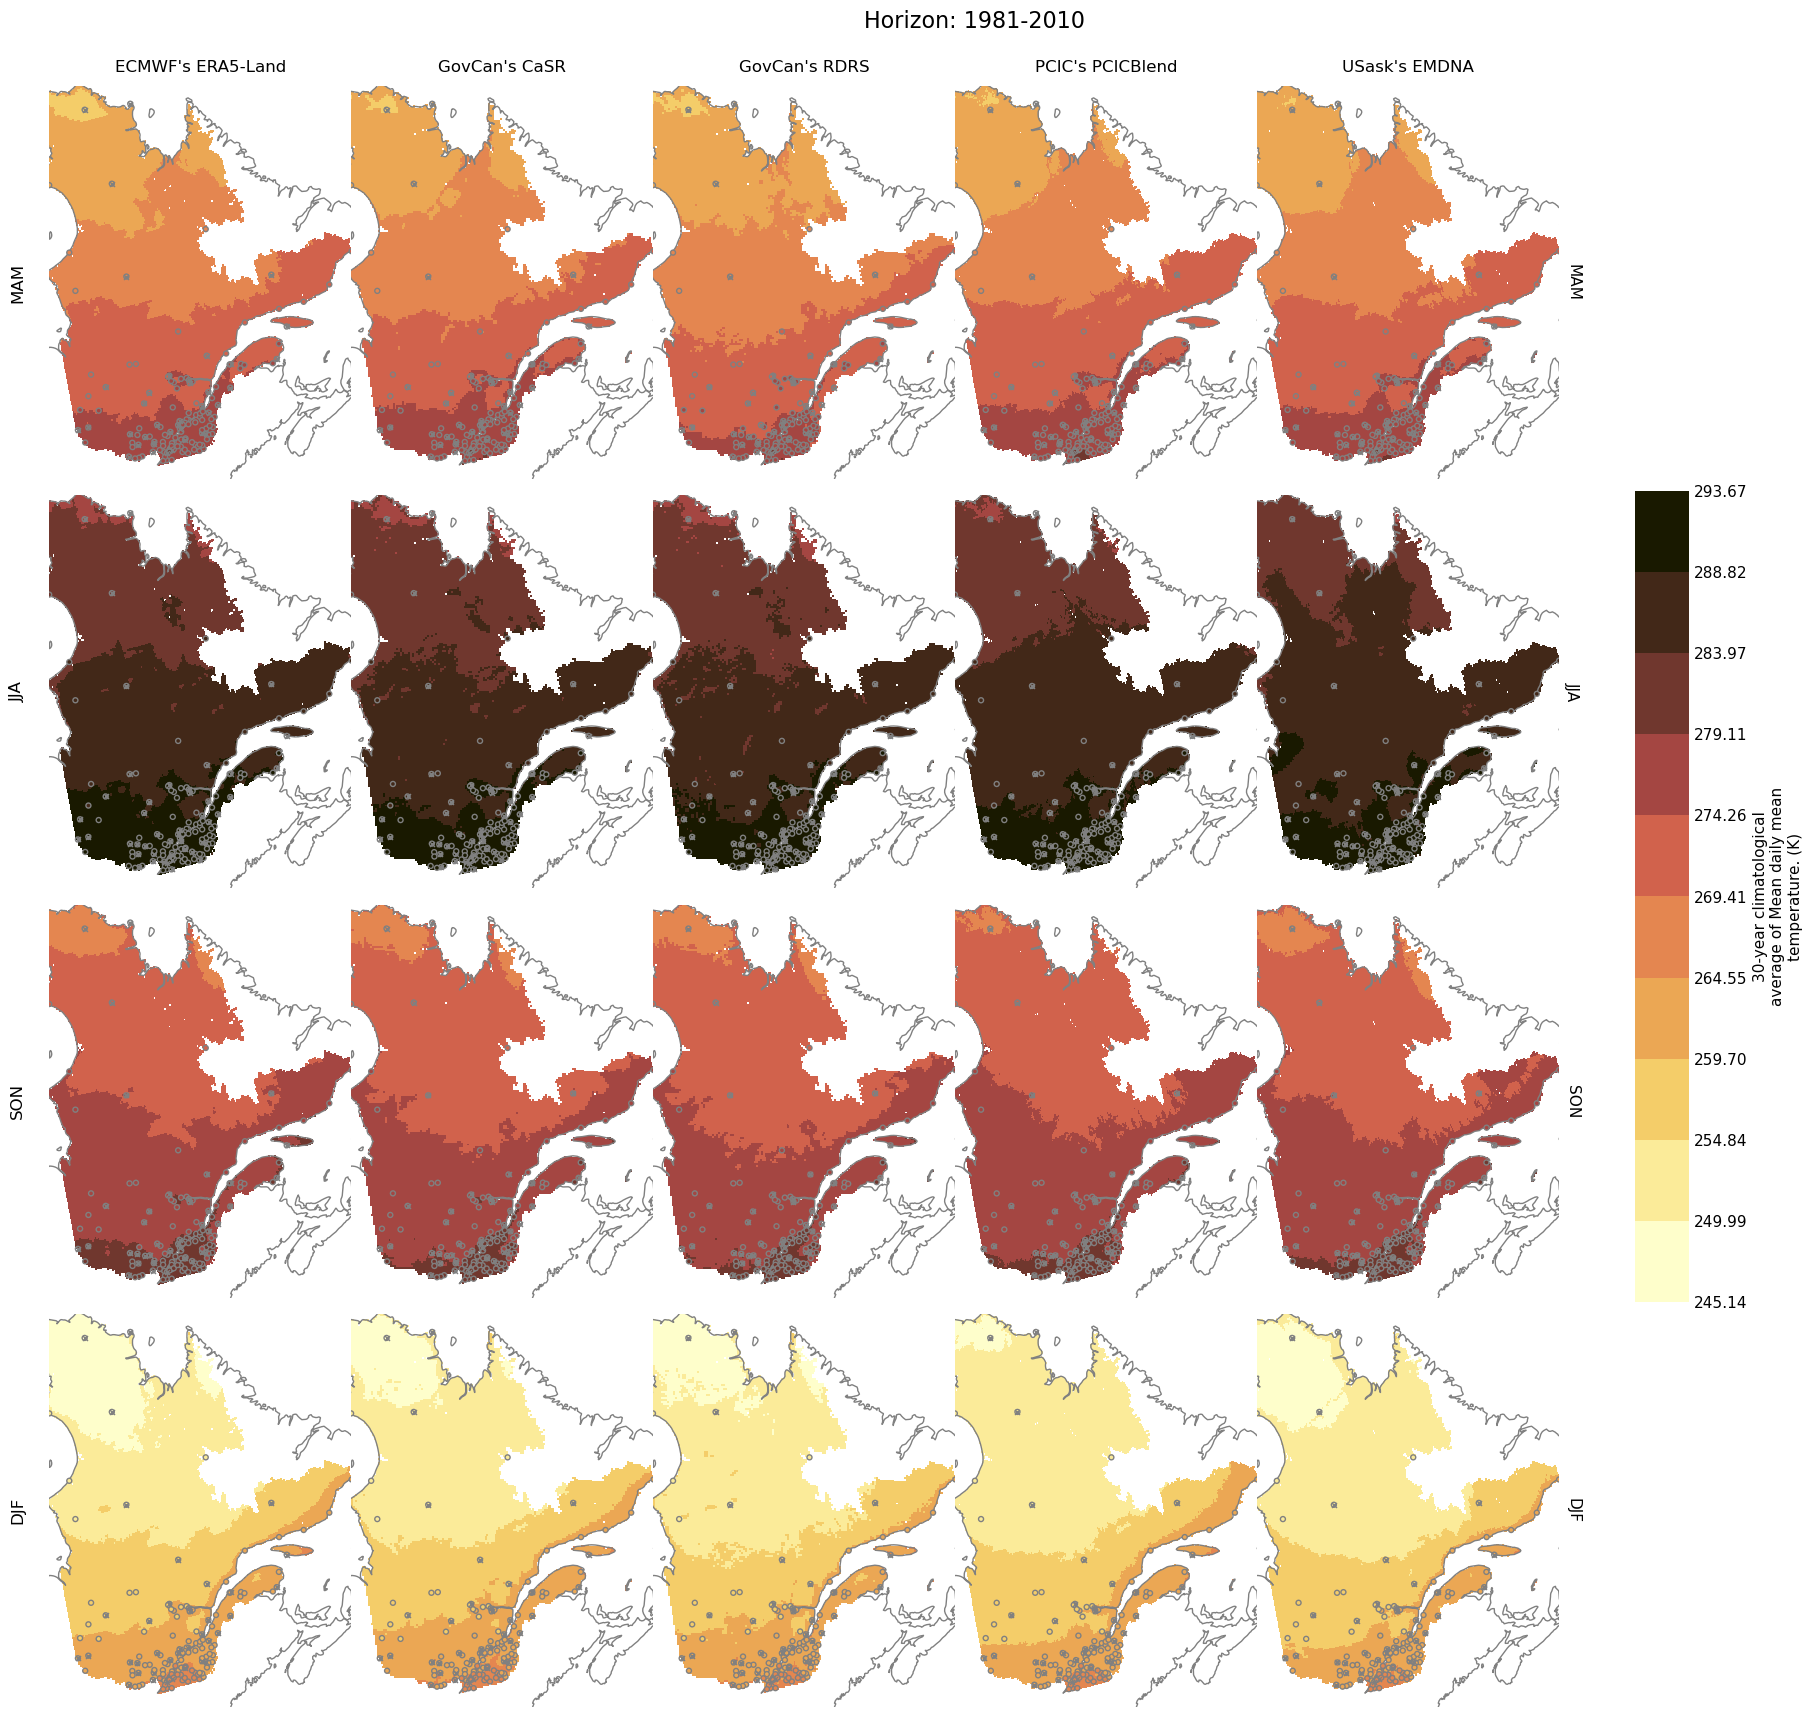

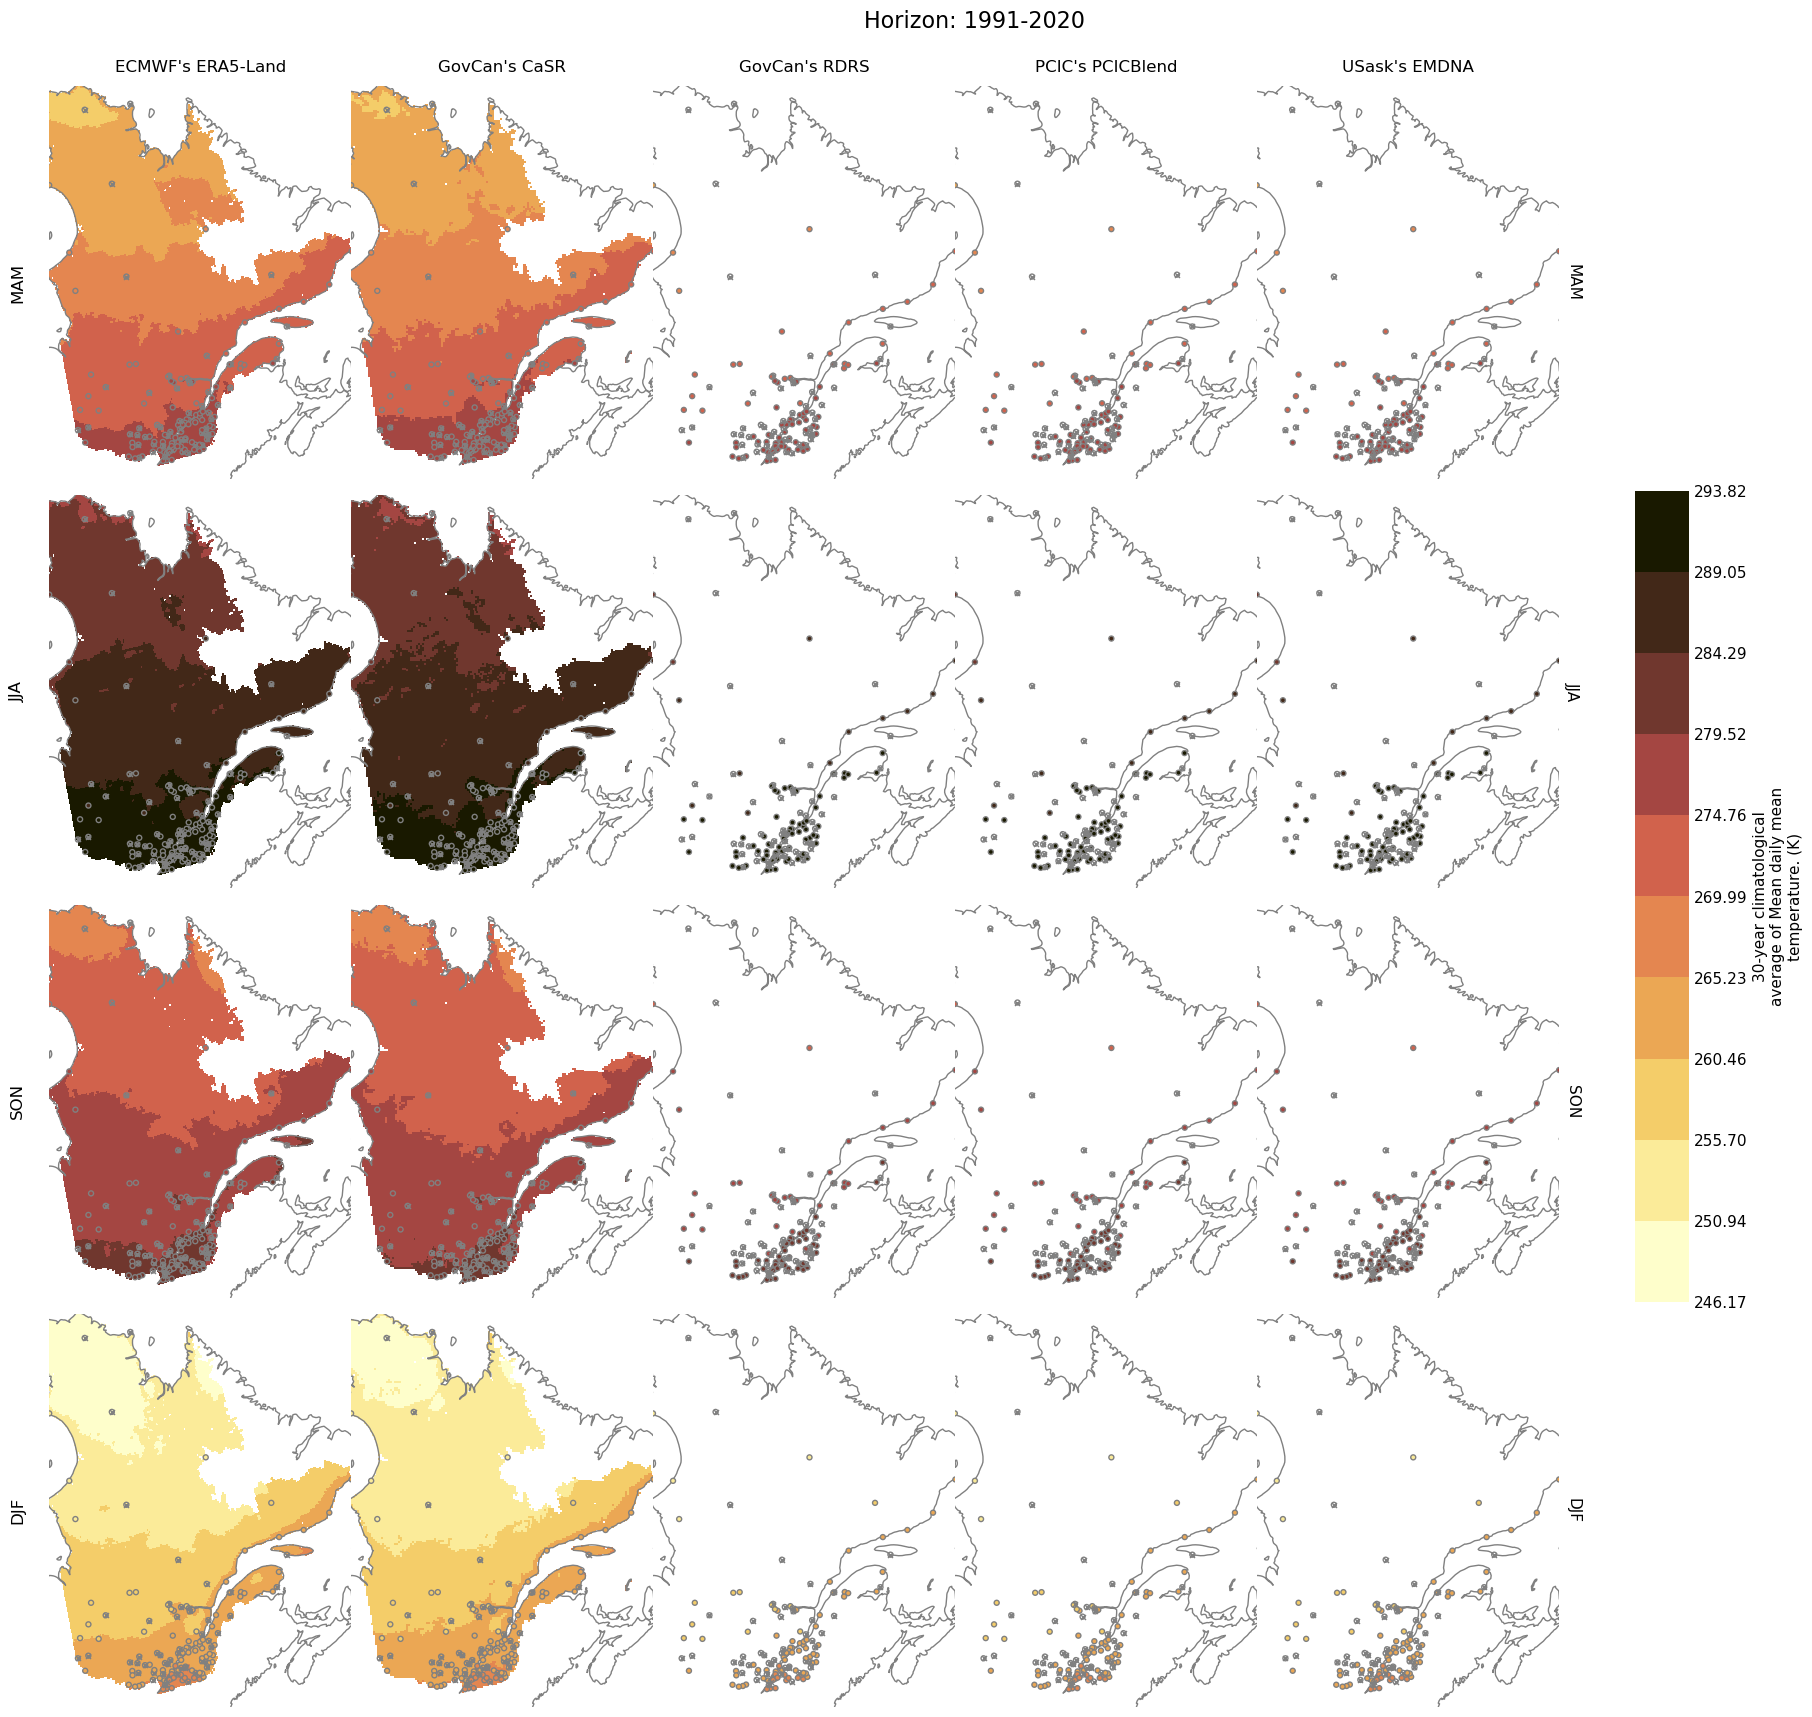

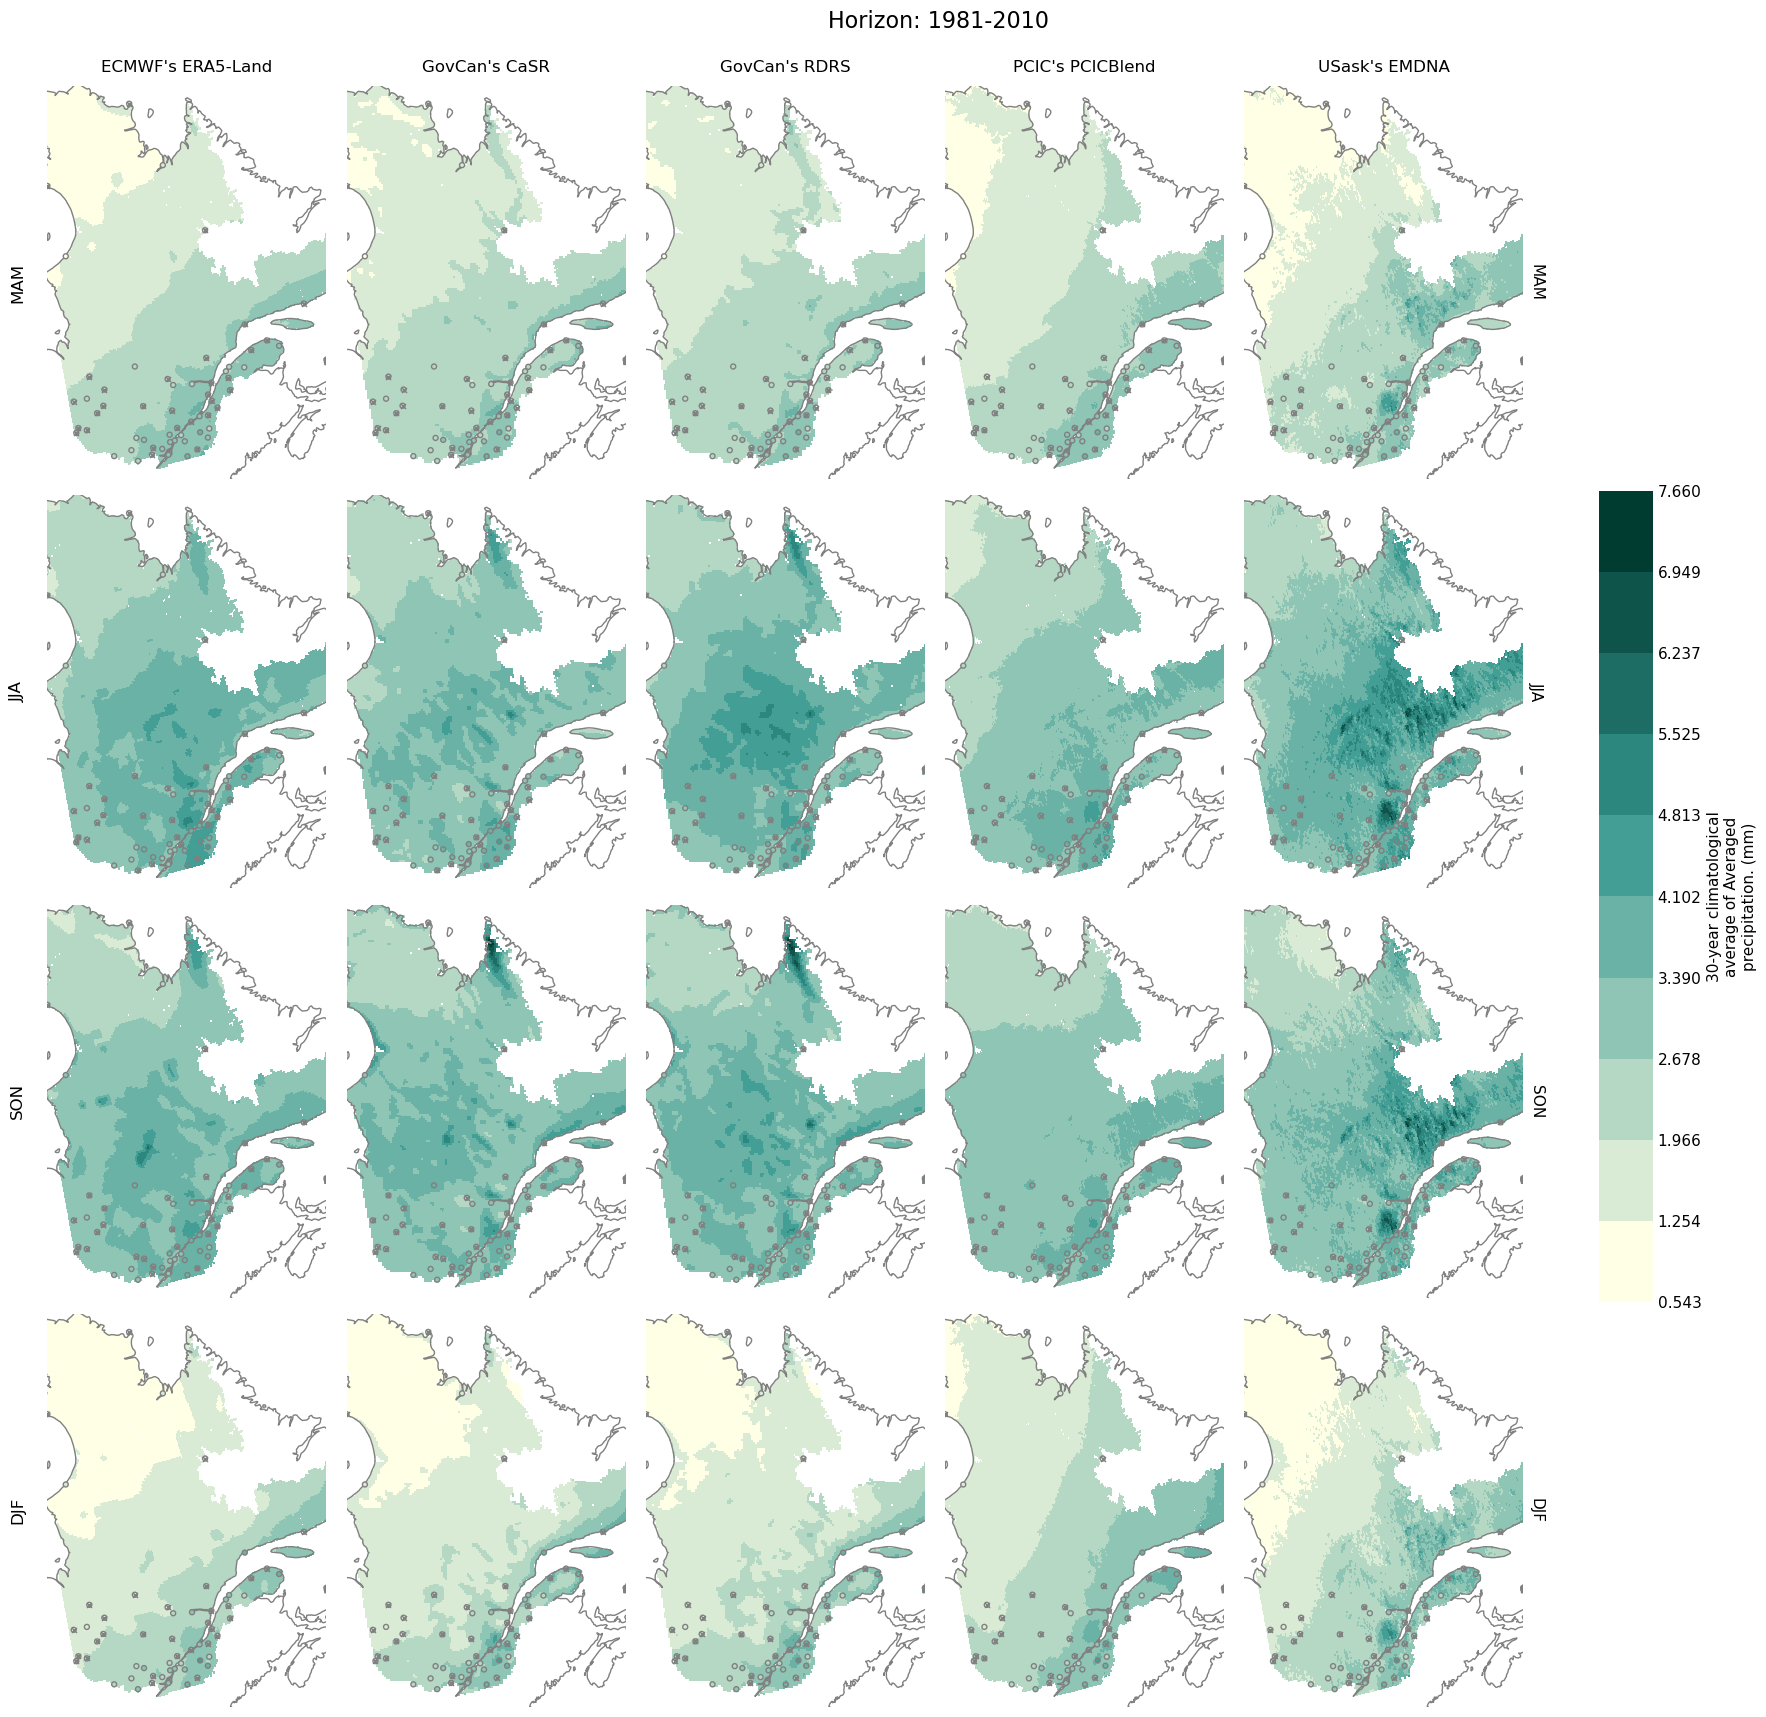

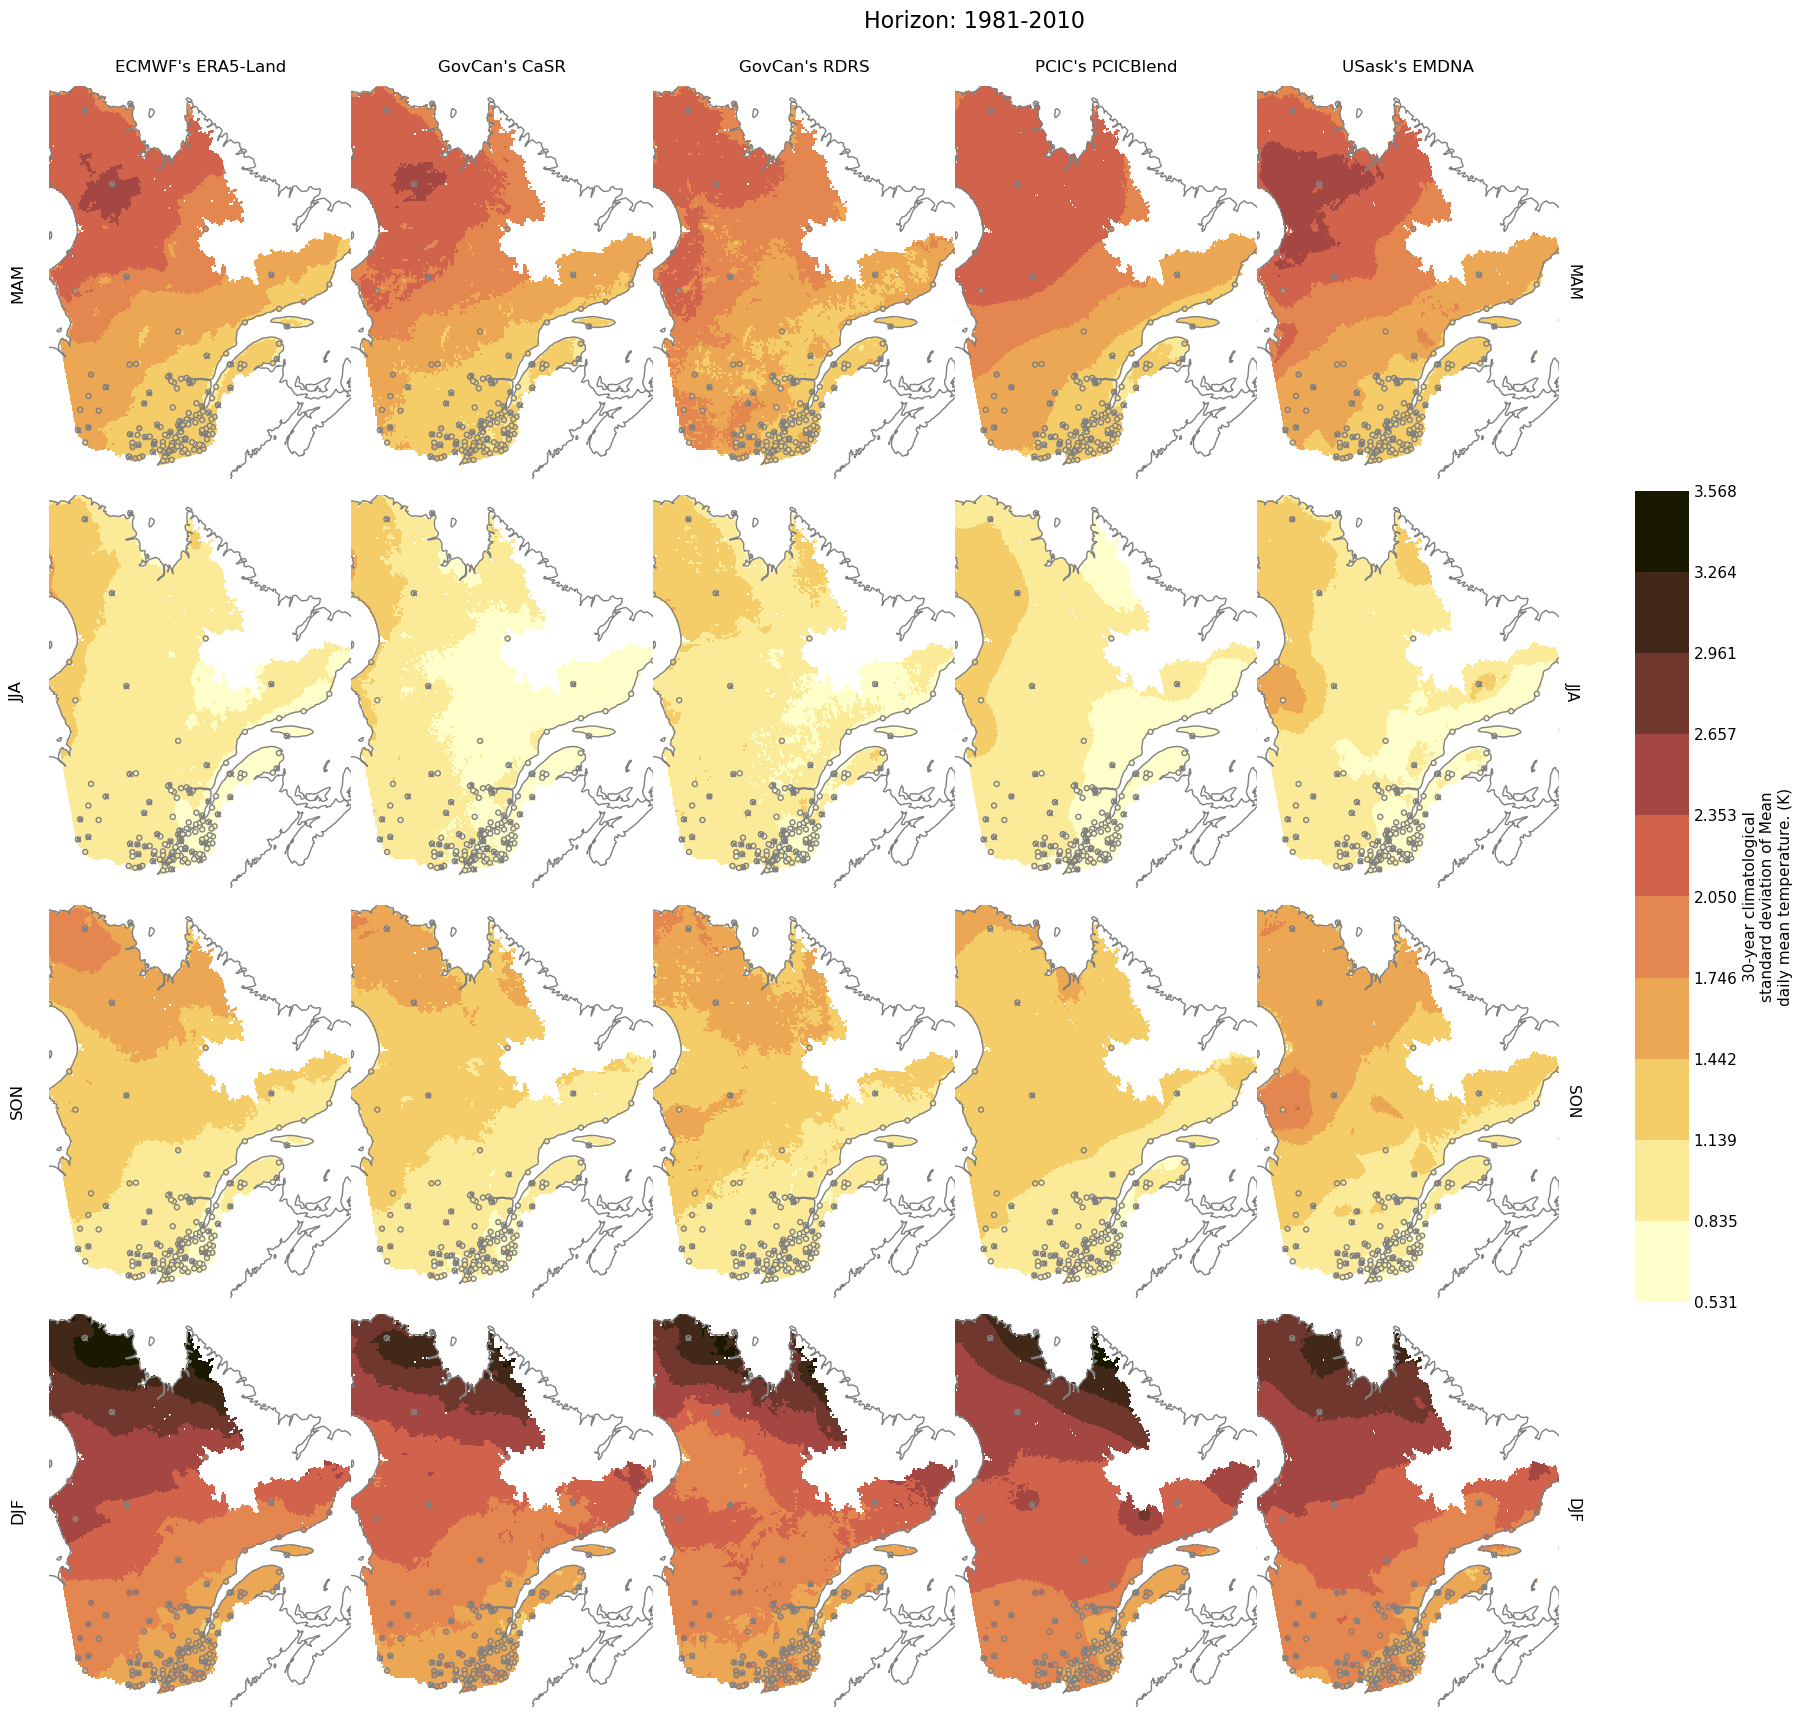

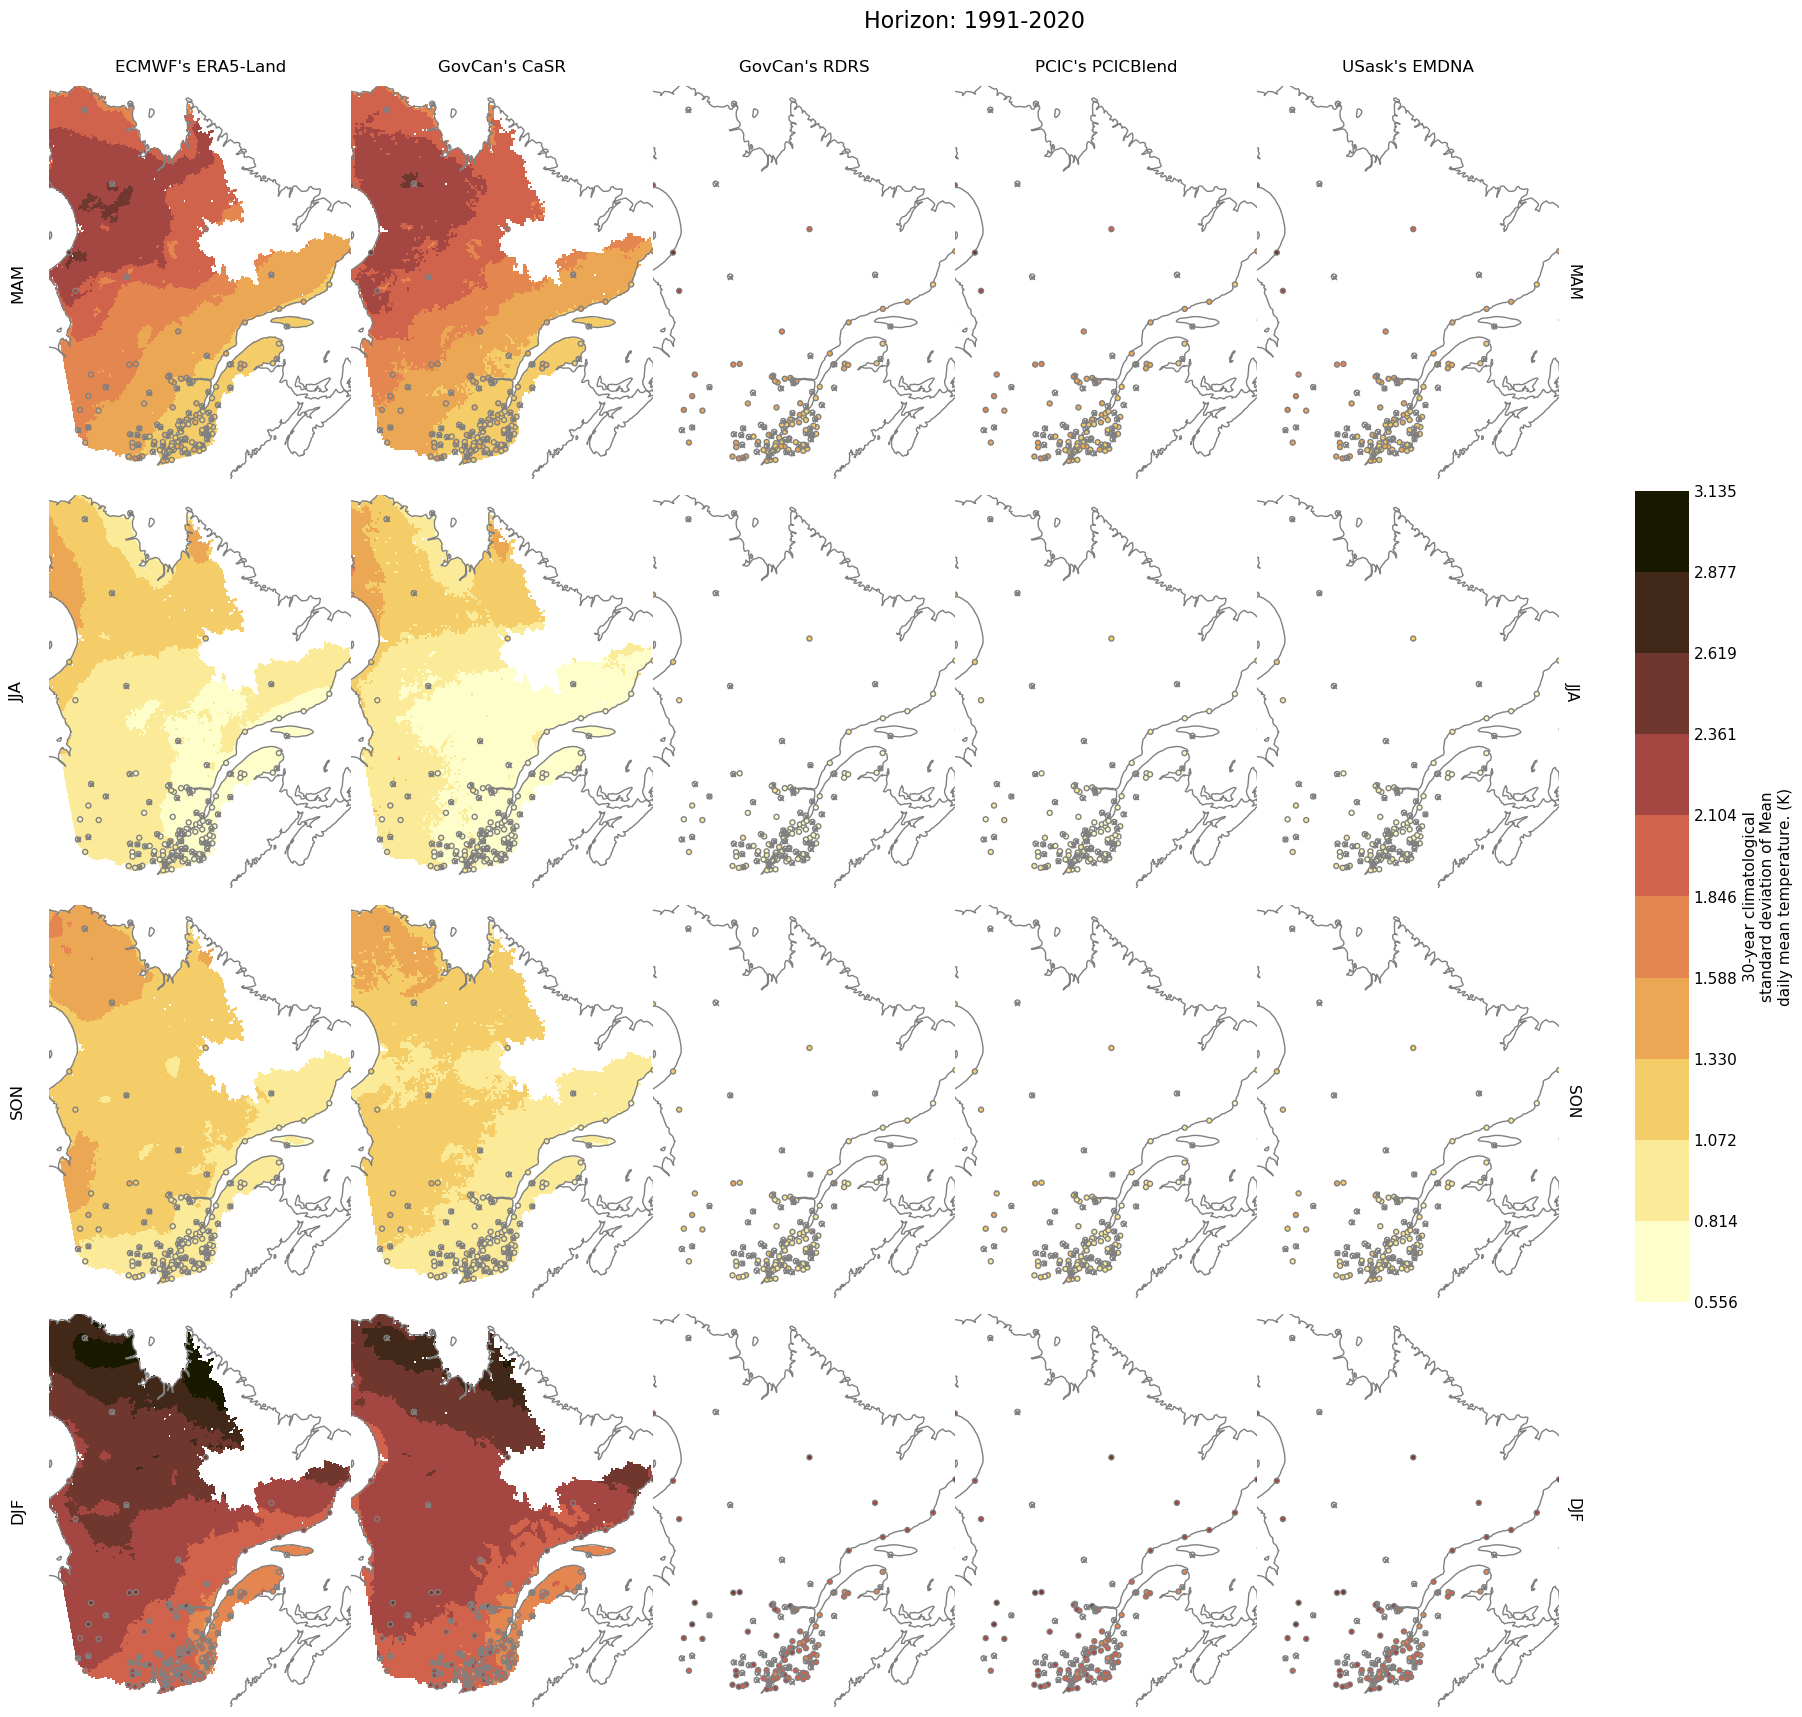

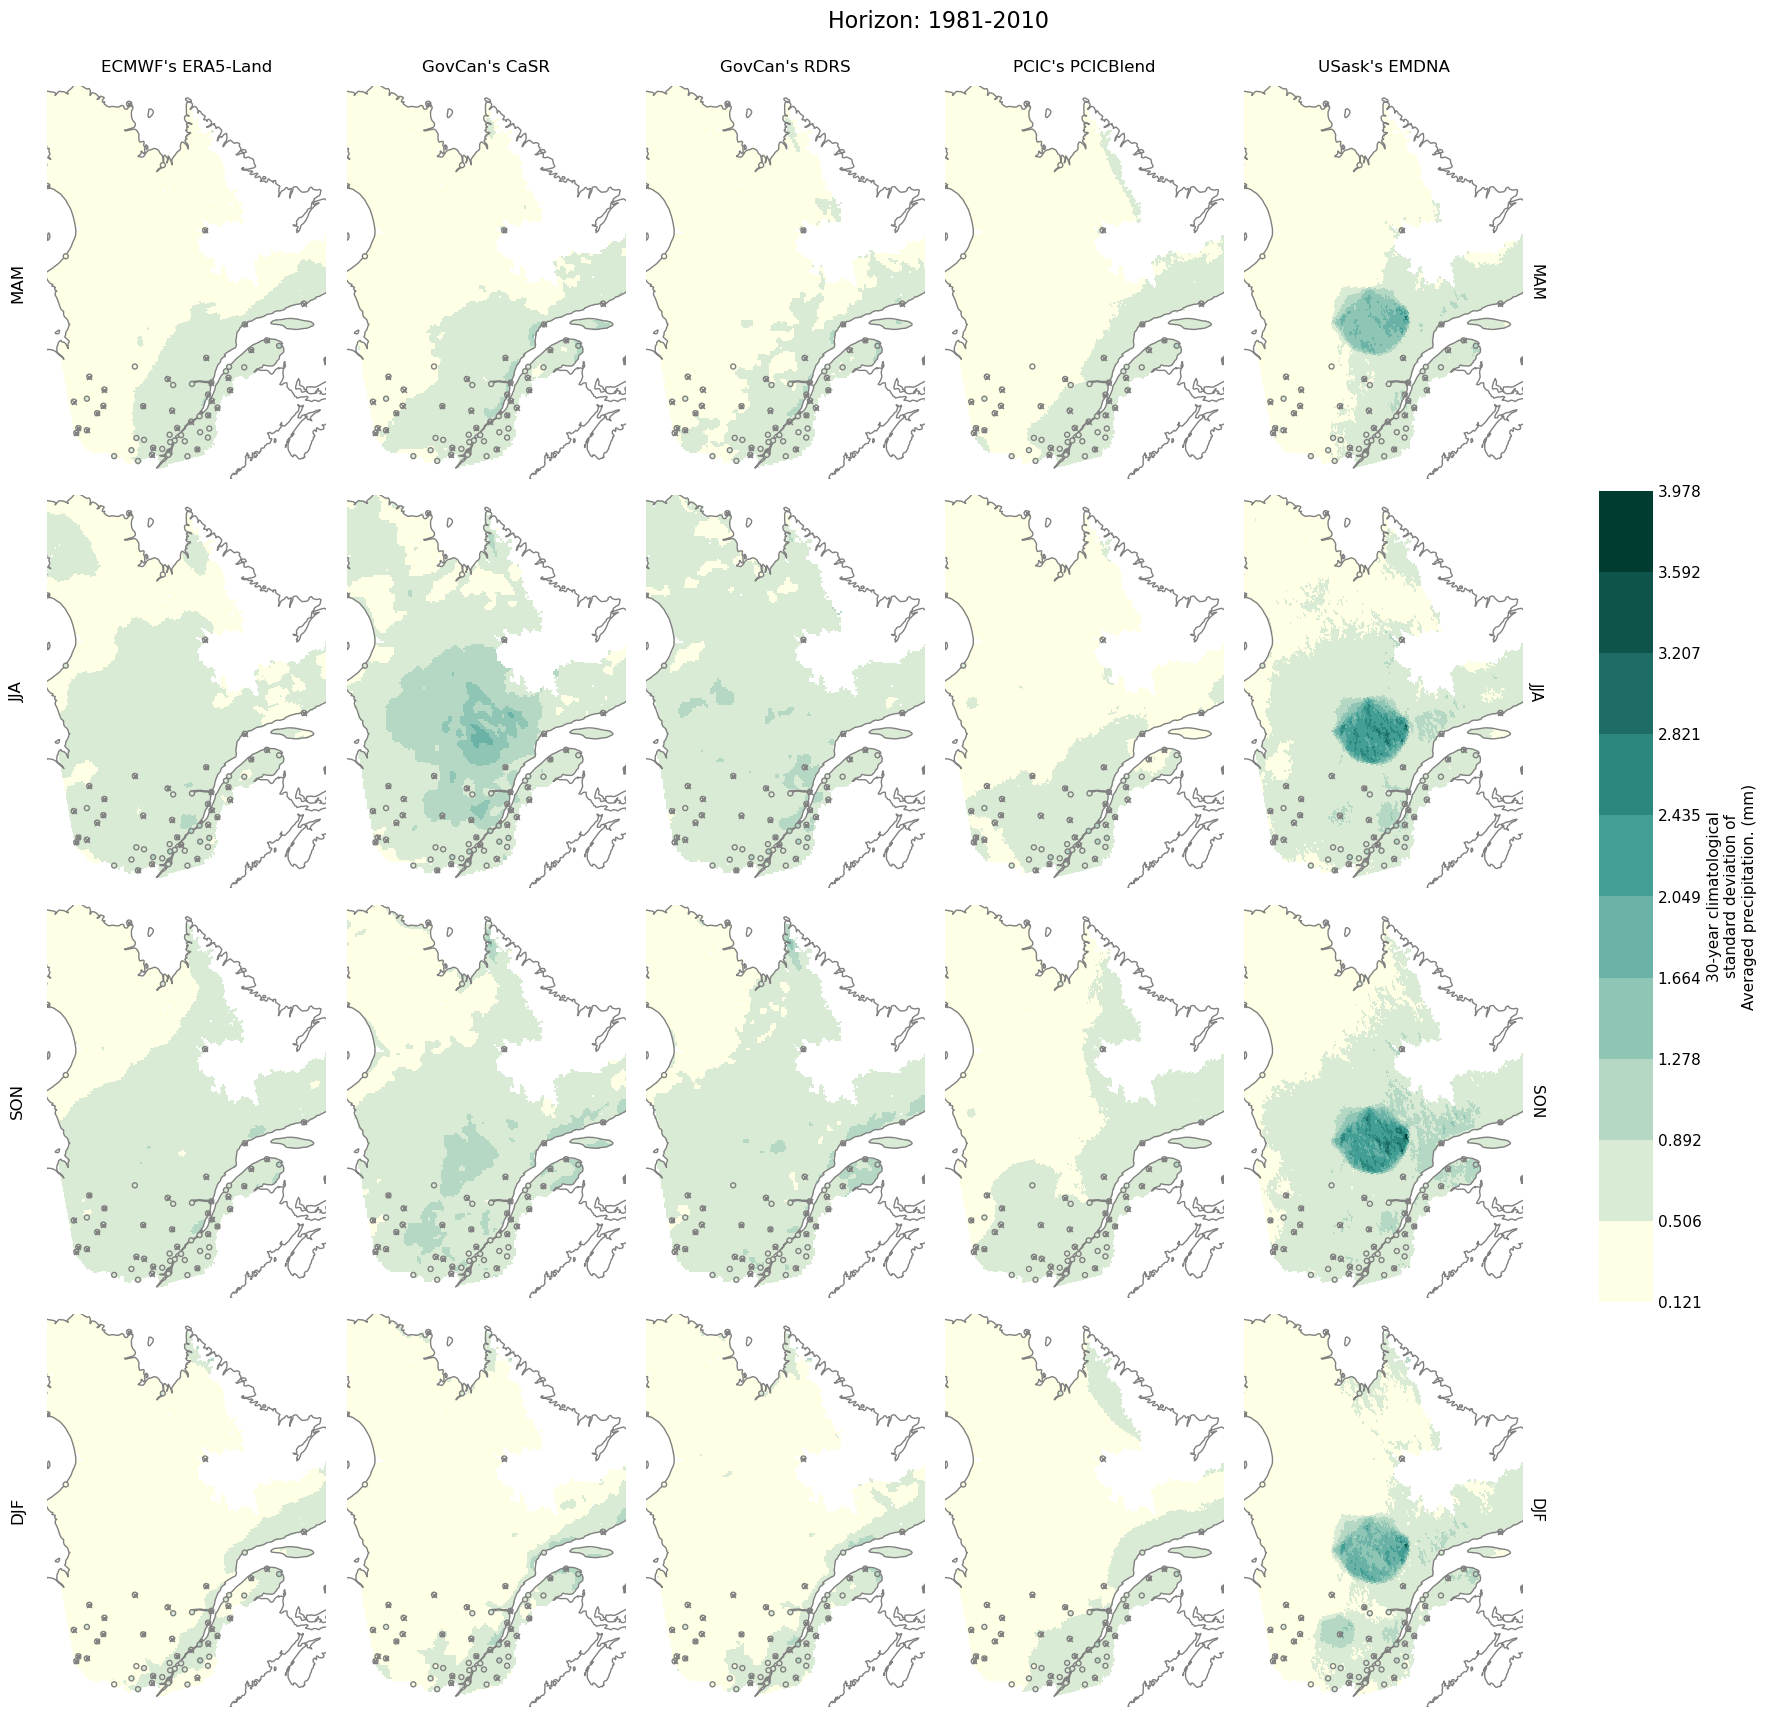

In [3]:
pcat_df_clim = pcat_df[pcat_df["processing_level"] == "climatology"]
variable_groups = pcat_df_clim["variable"].unique()
variables = set(item for group in variable_groups for item in group)

for clim_var in variables:
    print(f"Processing variable: {clim_var}")

    dt_obs = pcat.search(
        processing_level="climatology", variable=clim_var, source="AHCCD"
    ).to_dataset()

    dts_rec = pcat.search(
        processing_level="climatology", variable=clim_var, type="reconstruction"
    ).to_dataset_dict()

    obs_horizons = dt_obs.horizon.values

    for horizon in obs_horizons:
        # Skip if observation data is annual (i.e., no 'season' dimension)
        if "season" not in dt_obs[clim_var].dims:
            print(f"	Skipping {clim_var} — Horizon: {horizon} (annual data)")
            continue
        print(f"\tHorizon: {horizon}")

        obs_var = dt_obs[clim_var].sel(horizon=horizon)

        valid_rec_ids = []
        for rec_id, ds in dts_rec.items():
            if clim_var in ds and "horizon" in ds[clim_var].dims and horizon in ds[clim_var].horizon.values:
                valid_rec_ids.append(rec_id)

        all_rec_ids = sorted(list(dts_rec.keys()))
        obs_var = obs_var.expand_dims(rec_ds=all_rec_ids)

        # determine global vmin/vmax from obs and all matching recs
        vmin = obs_var.min().compute().item()
        vmax = obs_var.max().compute().item()
        for rec_id in valid_rec_ids:
            rec_val = dts_rec[rec_id][clim_var].sel(horizon=horizon)
            vmin = min(vmin, rec_val.min().compute().item())
            vmax = max(vmax, rec_val.max().compute().item())

        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        nlevels = 10
        levels = np.linspace(vmin, vmax, nlevels + 1)

        # === Split obs into valid/NaN ===
        mask_nan = obs_var.isnull().compute()
        mask_valid = ~mask_nan
        obs_nan = obs_var.where(mask_nan, drop=True)
        obs_valid = obs_var.where(mask_valid, drop=True)

        # === BASE PLOT: SCATTERMAP ===
        size_ratio = 1.2

        scatter = fg.scattermap(
            obs_var,
            projection=ccrs.LambertConformal(),
            fig_kw={"figsize": (3.2 * len(all_rec_ids) * size_ratio, 3.5 * len(obs_var.season) * size_ratio)},
            plot_kw={
                "row": "season",
                "col": "rec_ds",
                "norm": norm,
                "add_colorbar": True,
                "zorder": 3,
                "edgecolor": "grey",
                "s": 13,
                "linewidth": 0.3,
                "cbar_kwargs": {
                    "shrink": 0.5,   # height of colorbar relative to subplot stack
                    "aspect": 15,    # smaller = thinner
                    "pad": 0.04      # space between plots and colorbar
                }
            },
            levels=levels,
            show_time=False,
            features={"coastline": {"edgecolor": "gray"}},
            enumerate_subplots=True
        )

        # === OVERLAY: GRIDMAP ===
        # Add season labels on the leftmost column
        for i, season in enumerate(obs_var.season.values):
            scatter.axs[i, 0].annotate(
                str(season),
                xy=(-0.08, 0.5),
                xycoords='axes fraction',
                ha='right',
                va='center',
                fontsize=12,
                rotation=90
            )
            scatter.axs[i, len(all_rec_ids) - 1].set_title("")
            

        for i, season in enumerate(obs_var.season.values):
            for j, rec_id in enumerate(all_rec_ids):
                ax = scatter.axs[i, j]

                ds = dts_rec[rec_id]
                if clim_var not in ds:
                    rec_slice = None
                elif "season" not in ds[clim_var].dims or season not in ds[clim_var].season.values:
                    rec_slice = None
                elif "horizon" not in ds[clim_var].dims or horizon not in ds[clim_var].horizon.values:
                    rec_slice = None
                else:
                    rec_slice = ds[clim_var].sel(horizon=horizon, season=season)

                if rec_slice is not None:
                    fg.gridmap(
                    rec_slice,
                    ax=ax,
                    transform=ccrs.PlateCarree() if "lat" in rec_slice.dims else None,
                    plot_kw={
                        "norm": norm,
                        "add_colorbar": False,
                        "zorder": 1,
                    },
                    levels=levels,
                    frame=False,
                    show_time=False
                )
                    
                mask_subset = mask_nan.sel(season=season, rec_ds=rec_id)

                if mask_subset.any():
                    lon = obs_var["lon"].where(mask_subset, drop=True)
                    lat = obs_var["lat"].where(mask_subset, drop=True)

                    ax.scatter(
                        lon.values,
                        lat.values,
                        transform=ccrs.PlateCarree(),
                        color="gray",
                        marker="x",
                        zorder=4,
                        s=13,
                        linewidths=1
                    )

                # Set title after gridmap to prevent it from being overwritten
                ds_meta = dts_rec.get(rec_id)
                if ds_meta is not None:
                    if i==0: # If this is the first row of the plot
                        inst = ds_meta.attrs.get("cat:institution", "")
                        src = ds_meta.attrs.get("cat:source", "")
                        ax.set_title(f"{inst}'s {src}", fontsize=12)
                    else:
                        ax.set_title(None, fontsize=12)

        scatter.fig.suptitle("Horizon: {}".format(horizon), fontsize=16, y=1.02)
        scatter.cbar.set_ticks(levels)
        scatter.cbar.ax.tick_params(length=0)

        # Remove default facet titles added by xarray (e.g., 'season = DJF\nrec_ds = XYZ')
        for ax in scatter.axs.flat:
            title = ax.get_title()
            if "season =" in title or "rec_ds =" in title:
                ax.set_title("")


Text(0.5, 0.98, 'pr_mean_seasonal_clim_std — Horizon: 1981-2010')

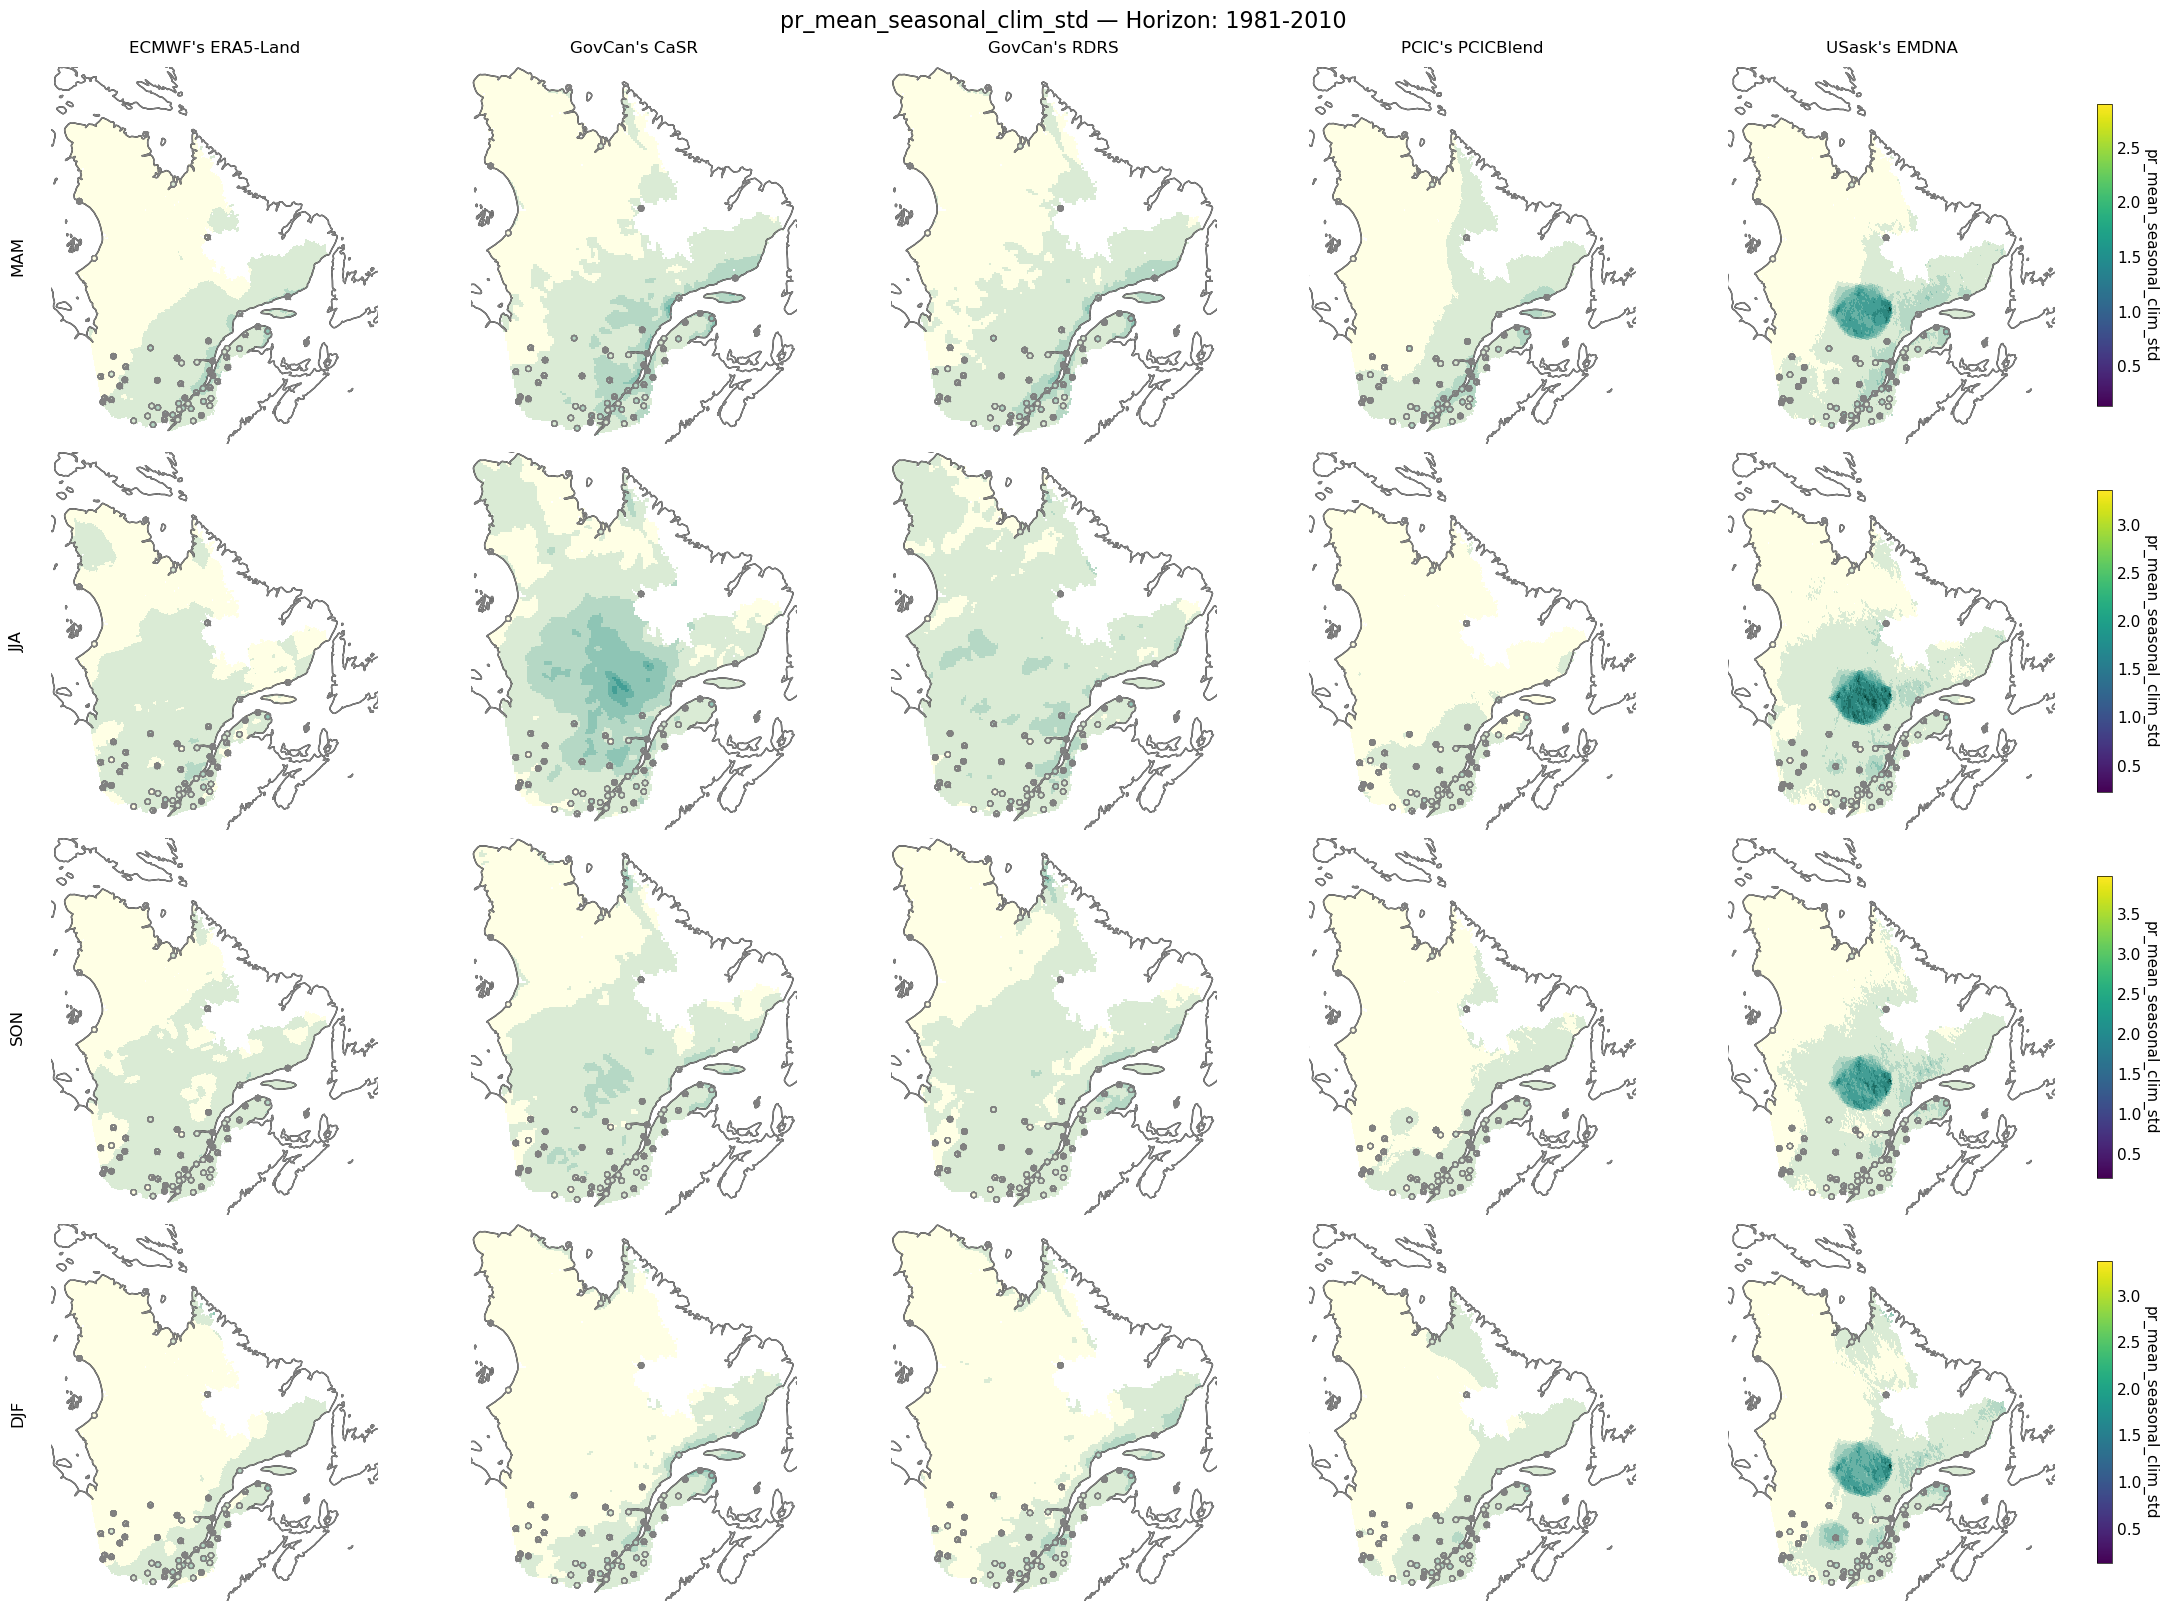

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import numpy as np

# Assume: obs_var, all_rec_ids, valid_rec_ids, dts_rec, mask_nan, clim_var, horizon are all pre-defined

n_seasons = len(obs_var.season)
n_models = len(all_rec_ids)

fig, axs = plt.subplots(
    nrows=n_seasons,
    ncols=n_models,
    figsize=(4.2 * n_models + 1.0, 4.0 * n_seasons),  # Custom figure size
    subplot_kw={'projection': ccrs.LambertConformal()},
    squeeze=False,
    constrained_layout=True  # Let Matplotlib handle padding
)

for i, season in enumerate(obs_var.season.values):
    season_label = str(season)

    vmin = obs_var.sel(season=season).min().values.item()
    vmax = obs_var.sel(season=season).max().values.item()

    for rec_id in valid_rec_ids:
        ds = dts_rec[rec_id]
        if (
            clim_var in ds and
            "season" in ds[clim_var].dims and
            season in ds[clim_var].season.values and
            "horizon" in ds[clim_var].dims and
            horizon in ds[clim_var].horizon.values
        ):
            rec_slice = ds[clim_var].sel(horizon=horizon, season=season).compute()
            vmin = min(vmin, rec_slice.min().values.item())
            vmax = max(vmax, rec_slice.max().values.item())

    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    levels = np.linspace(vmin, vmax, 11)

    for j, rec_id in enumerate(all_rec_ids):
        ax = axs[i, j]
        ax.coastlines()

        # Plot recon
        rec_slice = None
        if rec_id in dts_rec:
            ds = dts_rec[rec_id]
            if (
                clim_var in ds and
                "season" in ds[clim_var].dims and season in ds[clim_var].season.values and
                "horizon" in ds[clim_var].dims and horizon in ds[clim_var].horizon.values
            ):
                rec_slice = ds[clim_var].sel(horizon=horizon, season=season)

        if rec_slice is not None:
            fg.gridmap(
                rec_slice,
                ax=ax,
                transform=ccrs.PlateCarree() if "lat" in rec_slice.dims else None,
                plot_kw={"norm": norm, "add_colorbar": False, "zorder": 1},
                levels=levels,
                frame=False,
                show_time=False
            )

        fg.scattermap(
            obs_var,
            ax=ax,
            plot_kw={
                "norm": norm,
                "add_colorbar": False,
                "zorder": 3,
                "edgecolor": "grey",
                "s": 13,
                "linewidth": 0.3,
            },
            levels=levels,
            show_time=False,
            features={"coastline": {"edgecolor": "gray"}},
            frame=False
        )

        mask_subset = mask_nan.sel(season=season, rec_ds=rec_id)
        if mask_subset.any():
            lat_nan = obs_var["lat"].where(mask_subset, drop=True)
            lon_nan = obs_var["lon"].where(mask_subset, drop=True)
            ax.scatter(
                lon_nan.values, lat_nan.values,
                transform=ccrs.PlateCarree(),
                color="gray", marker="x", zorder=4, s=13, linewidths=1
            )

        if i == 0:
            ds_meta = dts_rec.get(rec_id)
            inst = ds_meta.attrs.get("cat:institution", "") if ds_meta else ""
            src = ds_meta.attrs.get("cat:source", "") if ds_meta else ""
            ax.set_title(f"{inst}'s {src}", fontsize=12)
        else:
            ax.set_title("")

        if j == 0:
            ax.annotate(
                season_label,
                xy=(-0.08, 0.5),
                xycoords='axes fraction',
                ha='right',
                va='center',
                fontsize=12,
                rotation=90
            )

    # Shared colorbar for the row
    sm = plt.cm.ScalarMappable(norm=norm)
    cbar = fig.colorbar(sm, ax=axs[i, :], orientation='vertical', shrink=0.8, pad=0.02)
    cbar.set_label(clim_var, rotation=270, labelpad=12)
    cbar.ax.tick_params(length=0)

fig.suptitle(f"{clim_var} — Horizon: {horizon}", fontsize=16)


## EMDNA Blob timeseries

In [5]:
ds_EMDNA_clim = pcat.search(processing_level="climatology", source="EMDNA", frequency="yr").to_dataset()
ds_EMDNA_clim

<xarray.Dataset> Size: 960kB
Dimensions:                   (horizon: 1, lat: 176, lon: 227)
Coordinates:
  * horizon                   (horizon) <U9 36B '1981-2010'
  * lat                       (lat) float32 704B 45.05 45.15 ... 62.45 62.55
  * lon                       (lon) float32 908B -79.65 -79.55 ... -57.15 -57.05
Data variables:
    pr_mean_annual_clim_mean  (horizon, lat, lon) float64 320kB dask.array<chunksize=(1, 176, 227), meta=np.ndarray>
    pr_mean_annual_clim_std   (horizon, lat, lon) float64 320kB dask.array<chunksize=(1, 176, 227), meta=np.ndarray>
    tg_mean_annual_clim_mean  (horizon, lat, lon) float32 160kB dask.array<chunksize=(1, 176, 227), meta=np.ndarray>
    tg_mean_annual_clim_std   (horizon, lat, lon) float32 160kB dask.array<chunksize=(1, 176, 227), meta=np.ndarray>
Attributes: (12/37)
    crs:                     EPSG:4326
    domain:                  NAM
    frequency:               day
    funding:                 Global Water Futures (GWF)
    history:                 [2025-07-01 12:41:00] shape spatial subsetting w...
    institution:             USask
    ...                      ...
    cat:domain:              Quebec
    cat:date_start:          1980-01-01 00:00:00
    cat:date_end:            2018-01-01 00:00:00
    cat:version:             v10
    cat:_data_format_:       zarr
    cat:path:                /tank/jlavoie/abuyalo/obsflow/climatology/USask_...

In [6]:
ds_EMDNA_ind = pcat.search(processing_level="indicators", source="EMDNA", frequency="yr").to_dataset()
ds_EMDNA_ind

<xarray.Dataset> Size: 19MB
Dimensions:         (lat: 176, lon: 227, time: 39)
Coordinates:
  * lat             (lat) float32 704B 45.05 45.15 45.25 ... 62.35 62.45 62.55
  * lon             (lon) float32 908B -79.65 -79.55 -79.45 ... -57.15 -57.05
  * time            (time) datetime64[ns] 312B 1980-01-01 ... 2018-01-01
Data variables:
    pr_mean_annual  (time, lat, lon) float64 12MB dask.array<chunksize=(39, 176, 227), meta=np.ndarray>
    tg_mean_annual  (time, lat, lon) float32 6MB dask.array<chunksize=(39, 176, 227), meta=np.ndarray>
Attributes: (12/37)
    crs:                     EPSG:4326
    domain:                  NAM
    frequency:               day
    funding:                 Global Water Futures (GWF)
    history:                 [2025-07-01 12:41:00] shape spatial subsetting w...
    institution:             USask
    ...                      ...
    cat:domain:              Quebec
    cat:date_start:          1980-01-01 00:00:00
    cat:date_end:            2018-01-01 00:00:00
    cat:version:             v10
    cat:_data_format_:       zarr
    cat:path:                /tank/jlavoie/abuyalo/obsflow/indicators/USask_E...

In [7]:
horizon = ds_EMDNA_clim.horizon.values
print(horizon)
pr_clim = ds_EMDNA_clim.isel(horizon=0).pr_mean_annual_clim_std


pr_ind = ds_EMDNA_ind.sel(time=slice("1981","2010")).pr_mean_annual

lat_on = 51.6
lon_on = -70.4
pr_ind_on = pr_ind.sel(lat=lat_on,lon=lon_on,method="nearest")

lat_off = 49.6
lon_off = -69
pr_ind_off = pr_ind.sel(lat=lat_off,lon=lon_off,method="nearest")


['1981-2010']


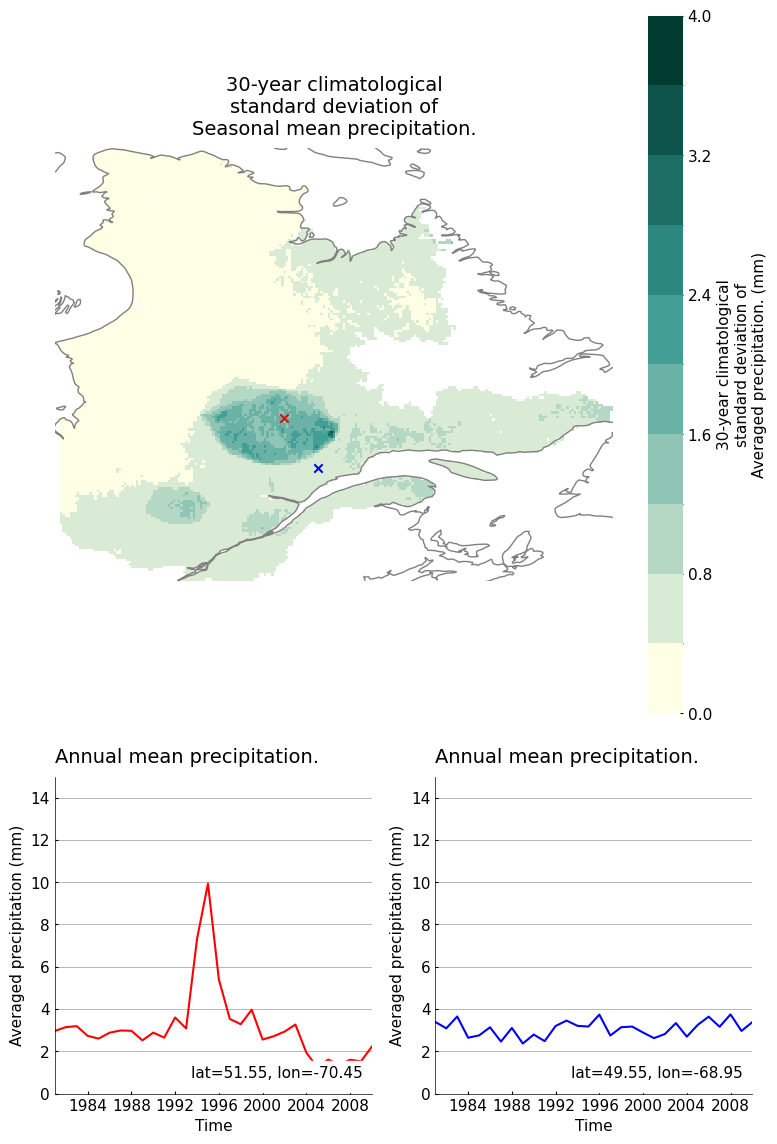

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs  # for PlateCarree

fig = plt.figure(figsize=(9, 14))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])  # 3 rows, 2 columns

# Insert the gridmap into the top 2x2 area
ax_map = fig.add_subplot(gs[0:2, :], projection=ccrs.PlateCarree())
ax = fg.gridmap(
    rec_slice,
    transform=ccrs.PlateCarree(),
    levels=10,
    frame=False,
    show_time=False,
    features={"coastline": {"edgecolor": "gray"}},
    ax=ax_map
)
ax.scatter(
    lon_on,
    lat_on,
    transform=ccrs.PlateCarree(),
    color="red",
    marker="x",
    zorder=4
)

ax.scatter(
    lon_off,
    lat_off,
    transform=ccrs.PlateCarree(),
    color="blue",
    marker="x",
    zorder=4
)

# Insert time series into bottom row
ylim = [0, 15]

ax_ts_left = fig.add_subplot(gs[2, 1])
ts_off = fg.timeseries(pr_ind_off, ax=ax_ts_left, plot_kw={"color": "blue"})
ax_ts_left.set_ylim(ylim)

ax_ts_right = fig.add_subplot(gs[2, 0])
ts_on = fg.timeseries(pr_ind_on, ax=ax_ts_right, plot_kw={"color": "red"})
ax_ts_right.set_ylim(ylim)

plt.show()
